In [27]:
!pip install mysql-connector-python==8.0.26
import pandas as pd
import mysql.connector
from mysql.connector import connect
from getpass import getpass
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns

### Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features.

In [2]:
db = connect(
host = "127.0.0.1",
user = 'root',
passwd = getpass('Enter password:'),
database = 'sakila') 

Enter password:········


In [3]:
cursor = db.cursor()

In [4]:
film_rental_data = """SELECT f.film_id, f.title, f.release_year, f.language_id, f.rental_duration, f.rental_rate, f.length, f.replacement_cost, f.rating
FROM film as f
JOIN inventory as inv
ON f.film_id = inv.film_id
JOIN rental r
ON inv.inventory_id = r.inventory_id
GROUP BY f.film_id"""

In [5]:
cursor.execute(film_rental_data)

### Read the data into a Pandas dataframe.

In [6]:
data = pd.DataFrame(cursor.fetchall())
data.head()

,0,1,2,3,4,5,6,7,8
0,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG
1,2,ACE GOLDFINGER,2006,1,3,4.99,48,12.99,G
2,3,ADAPTATION HOLES,2006,1,7,2.99,50,18.99,NC-17
3,4,AFFAIR PREJUDICE,2006,1,5,2.99,117,26.99,G
4,5,AFRICAN EGG,2006,1,6,2.99,130,22.99,G


In [7]:
data = data.rename(columns={0: 'film_id', 1: 'title', 2: 'release_year', 3: 'language_id', 4: 'rental_duration', 5: 'rental_rate', 6: 'film_length', 7: 'replacement_cost', 8: 'film_rating'})
data.head()

,film_id,title,release_year,language_id,rental_duration,rental_rate,film_length,replacement_cost,film_rating
0,1,ACADEMY DINOSAUR,2006,1,6,0.99,86,20.99,PG
1,2,ACE GOLDFINGER,2006,1,3,4.99,48,12.99,G
2,3,ADAPTATION HOLES,2006,1,7,2.99,50,18.99,NC-17
3,4,AFFAIR PREJUDICE,2006,1,5,2.99,117,26.99,G
4,5,AFRICAN EGG,2006,1,6,2.99,130,22.99,G


### Analyze extracted features and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [8]:
data.shape

(958, 9)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958 entries, 0 to 957
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   film_id           958 non-null    int64 
 1   title             958 non-null    object
 2   release_year      958 non-null    int64 
 3   language_id       958 non-null    int64 
 4   rental_duration   958 non-null    int64 
 5   rental_rate       958 non-null    object
 6   film_length       958 non-null    int64 
 7   replacement_cost  958 non-null    object
 8   film_rating       958 non-null    object
dtypes: int64(5), object(4)
memory usage: 67.5+ KB


In [10]:
data["rental_rate"] = data["rental_rate"].astype("int64")
data["replacement_cost"] = data["replacement_cost"].astype("int64")

In [11]:
data.isna().sum()

film_id             0
title               0
release_year        0
language_id         0
rental_duration     0
rental_rate         0
film_length         0
replacement_cost    0
film_rating         0
dtype: int64

In [12]:
data.language_id.unique()

array([1])

In [13]:
data = data.drop(["language_id"], axis = 1)
data.head()

,film_id,title,release_year,rental_duration,rental_rate,film_length,replacement_cost,film_rating
0,1,ACADEMY DINOSAUR,2006,6,0,86,20,PG
1,2,ACE GOLDFINGER,2006,3,4,48,12,G
2,3,ADAPTATION HOLES,2006,7,2,50,18,NC-17
3,4,AFFAIR PREJUDICE,2006,5,2,117,26,G
4,5,AFRICAN EGG,2006,6,2,130,22,G


In [14]:
data.release_year.unique()

array([2006])

In [15]:
data = data.drop(["release_year"], axis = 1)
data.head()

,film_id,title,rental_duration,rental_rate,film_length,replacement_cost,film_rating
0,1,ACADEMY DINOSAUR,6,0,86,20,PG
1,2,ACE GOLDFINGER,3,4,48,12,G
2,3,ADAPTATION HOLES,7,2,50,18,NC-17
3,4,AFFAIR PREJUDICE,5,2,117,26,G
4,5,AFRICAN EGG,6,2,130,22,G


In [16]:
scaler = StandardScaler()
num_cols = ['rental_duration', 'rental_rate', 'film_length', 'replacement_cost']
data[num_cols] = scaler.fit_transform(data[num_cols])
data.head()

,film_id,title,rental_duration,rental_rate,film_length,replacement_cost,film_rating
0,1,ACADEMY DINOSAUR,0.732321,-1.210182,-0.729050,0.153556,PG
1,2,ACE GOLDFINGER,-1.400090,1.225436,-1.668465,-1.167269,G
2,3,ADAPTATION HOLES,1.443124,0.007627,-1.619022,-0.176650,NC-17
3,4,AFFAIR PREJUDICE,0.021517,0.007627,0.037314,1.144175,G
4,5,AFRICAN EGG,0.732321,0.007627,0.358693,0.483762,G


In [17]:
data.film_rating.unique()

array(['PG', 'G', 'NC-17', 'PG-13', 'R'], dtype=object)

In [18]:
data = pd.get_dummies(data, columns=['film_rating'])
data.head()

,film_id,title,rental_duration,rental_rate,film_length,replacement_cost,film_rating_G,film_rating_NC-17,film_rating_PG,film_rating_PG-13,film_rating_R
0,1,ACADEMY DINOSAUR,0.732321,-1.210182,-0.729050,0.153556,0,0,1,0,0
1,2,ACE GOLDFINGER,-1.400090,1.225436,-1.668465,-1.167269,1,0,0,0,0
2,3,ADAPTATION HOLES,1.443124,0.007627,-1.619022,-0.176650,0,1,0,0,0
3,4,AFFAIR PREJUDICE,0.021517,0.007627,0.037314,1.144175,1,0,0,0,0
4,5,AFRICAN EGG,0.732321,0.007627,0.358693,0.483762,1,0,0,0,0


### Create a query to get the list of films and a boolean indicating if it was rented last month. This would be our target variable.

In [19]:
film_rental_data = """SELECT f.film_id, 
       MAX(CASE WHEN r.rental_id IS NULL THEN 0 ELSE 1 END) AS rented_last_month
FROM film f
LEFT JOIN inventory inv ON f.film_id = inv.film_id
LEFT JOIN rental r ON inv.inventory_id = r.inventory_id
    AND r.rental_date BETWEEN '2006-02-01' AND '2006-02-28'
GROUP BY f.film_id;"""

In [20]:
cursor.execute(film_rental_data)

In [21]:
target = pd.DataFrame(cursor.fetchall())
target.head()

,0,1
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1


In [22]:
target = target.rename(columns={0: 'film_id', 1: 'rented_last_month'})
target.head()

,film_id,rented_last_month
0,1,0
1,2,1
2,3,0
3,4,1
4,5,1


In [23]:
full_data = pd.merge(data, target, on='film_id')
full_data.head()

,film_id,title,rental_duration,rental_rate,film_length,replacement_cost,film_rating_G,film_rating_NC-17,film_rating_PG,film_rating_PG-13,film_rating_R,rented_last_month
0,1,ACADEMY DINOSAUR,0.732321,-1.210182,-0.729050,0.153556,0,0,1,0,0,0
1,2,ACE GOLDFINGER,-1.400090,1.225436,-1.668465,-1.167269,1,0,0,0,0,1
2,3,ADAPTATION HOLES,1.443124,0.007627,-1.619022,-0.176650,0,1,0,0,0,0
3,4,AFFAIR PREJUDICE,0.021517,0.007627,0.037314,1.144175,1,0,0,0,0,1
4,5,AFRICAN EGG,0.732321,0.007627,0.358693,0.483762,1,0,0,0,0,1


In [34]:
full_data['rented_last_month'].value_counts()

0    790
1    168
Name: rented_last_month, dtype: int64

### Create a logistic regression model to predict this variable from the cleaned data.

In [25]:
y = full_data['rented_last_month']
cols_to_drop = ['film_id', 'title', 'rented_last_month']
X = full_data.drop(cols_to_drop, axis=1)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [30]:
classification = LogisticRegression(random_state=0, multi_class='ovr').fit(X_train, y_train)

In [31]:
predictions = classification.predict(X_test)

### Evaluate the results.

In [32]:
pd.Series(predictions).value_counts()

0    288
dtype: int64

In [35]:
y_test.value_counts()

0    237
1     51
Name: rented_last_month, dtype: int64

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[237,   0],
       [ 51,   0]])

In [41]:
classification.score(X_test, y_test)

0.8229166666666666

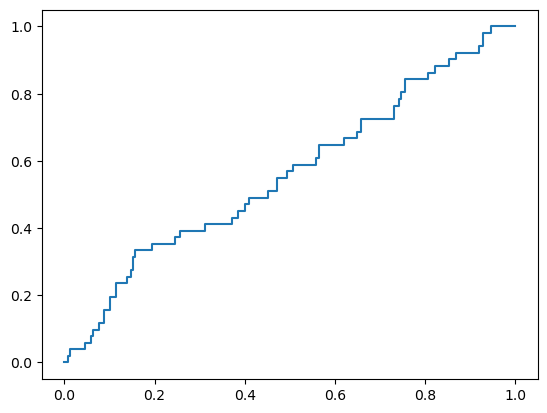

In [43]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_pred_proba = classification.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr)